In [38]:
# preparation of the environment
%load_ext autoreload
%autoreload 2

INF = 1e30

from tqdm.notebook import tqdm

import os
from os import path
# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)

import pandas as pd
import numpy as np
import torch
from training_bert import BertNliLight
from regularize_training_bert import SNLIDataModule
from regularize_training_bert import BertNliRegu
from torch.utils.data import DataLoader

# --> from this environment
from attention_algorithms.raw_attention import RawAttention
from attention_algorithms.attention_metrics import normalize_attention

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# the different models
models_dict = {}
for r in [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.08, 0.1, 0.4]:
    model = None
    if r==0:
        ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
        model = BertNliLight.load_from_checkpoint(ckp)
    else :
        ckp = path.join(".cache", "logs", "igrida_trained", f"reg_mul={r}", "best.ckpt")
        model = BertNliRegu.load_from_checkpoint(ckp)
    models_dict[f"reg_mul={r}"] = model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 

In [40]:
data_dir = os.path.join(".cache", "raw_data", "e_snli")

dm = SNLIDataModule(cache=data_dir,
                   batch_size = 1,
                   num_workers = 4,
                   nb_data = 99)

dm.prepare_data()

dm.setup(stage="test")

test_dataset = dm.test_set
test_dataloader = dm.test_dataloader()

## The KL divergence

In [41]:
import torch.nn.functional as F
KL_divergence_dict = {}


for r in [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.08, 0.1, 0.4]:
    KL_divergence_dict[f"reg_mul={r}"] = torch.zeros((12, 12, 99))

with torch.no_grad():
    for id_batch, batch in tqdm(enumerate(test_dataloader), total = len(test_dataset)):

        ids = batch["input_ids"]
        mk = batch["attention_masks"]
        labels = batch["labels"]
        a_true = batch["annotations"]
        spe_tok_mask = torch.isin(ids, torch.tensor([0, 101, 102])).type(torch.uint8)[0]
        
        for r in [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.08, 0.1, 0.4]:
            raw_attention_inst = RawAttention(model = models_dict[f"reg_mul={r}"],
                                             input_ids = ids,
                                             attention_mask = mk,
                                             test_mod = False
                                             )
            for h in range(12):
                for h_p in range(12):
                    a_hat_h = raw_attention_inst.attention_tensor[0, 2, h, :, :].sum(dim=0)
                    a_hat_h = torch.softmax(a_hat_h - INF*spe_tok_mask[0:len(raw_attention_inst.tokens)],dim=0)
                    a_hat_h_p = raw_attention_inst.attention_tensor[0, 2, h_p, :, :].sum(dim=0)
                    a_hat_h_p = torch.softmax(a_hat_h_p - INF*spe_tok_mask[0:len(raw_attention_inst.tokens)], dim=0)
                    
                    KL_divergence_dict[f"reg_mul={r}"][h, h_p, id_batch] = F.kl_div(a_hat_h, a_hat_h_p)                  
                    

  0%|          | 0/99 [00:00<?, ?it/s]

C:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torch\nn\functional.py:2905: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


In [42]:
mean_s = {}
var_s = {}

x = []
y = []

for r in [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.08, 0.1, 0.4]:
    mean_s[f"reg_mul={r}"] = KL_divergence_dict[f"reg_mul={r}"].mean(dim=-1)
    var_s[f"reg_mul={r}"] = KL_divergence_dict[f"reg_mul={r}"].var(dim=-1)
    
    x += [f"reg_mul={r}"]*int(12*12)
    
    y += list(mean_s[f"reg_mul={r}"].flatten().numpy())

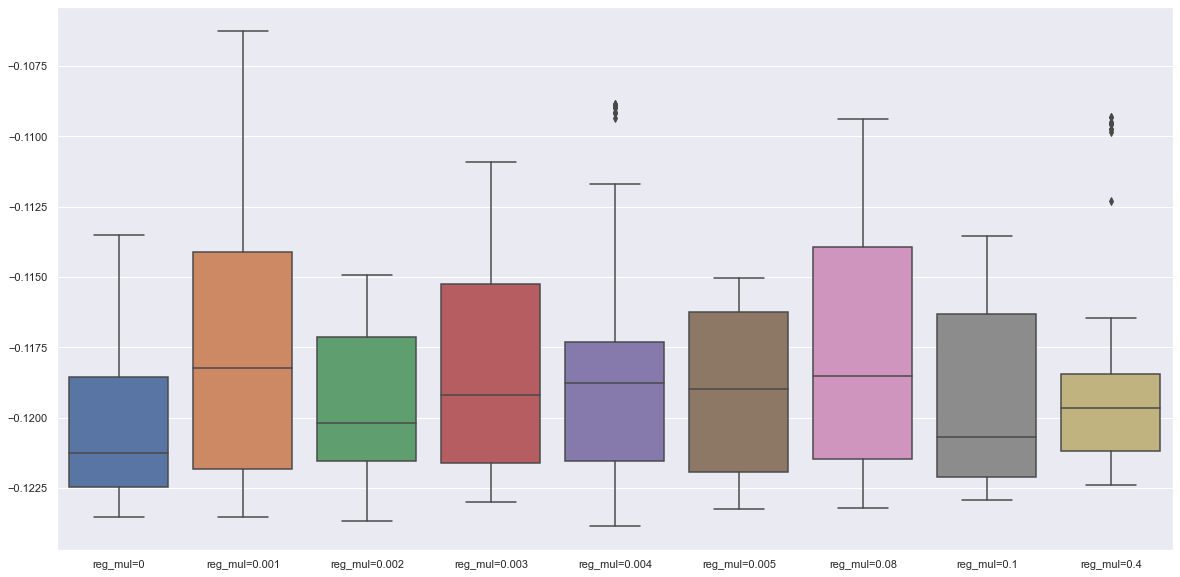

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax = sns.boxplot(x = x, y = y)
plt.savefig(os.path.join(os.getcwd(), ".cache", "plots", "reg_compensation_study", "kl_divergence.png"))

## Look at the distribution for 

In [46]:
def html_render(model_outputs):
    html = ''
    table_len = len(model_outputs['GROUNDTRUTH']['Entropy'])
    for i in range(table_len):
        html += '<table>'
        html += '<tr><th></th>' # One xtra head for model's name
        for column_name in model_outputs['GROUNDTRUTH'].keys():
            html+= '<th>'+ column_name +'</th>'
        html += ' </tr>'
        for name, model_content in model_outputs.items():
            html += '<tr>'
            html += '<td><b>' + name + '</b></td>'

            for k, output in model_content.items():
                displ = output[i] if output is not None else 'N/A'
                if isinstance(displ, float):
                    displ = str(round(displ, 3))
                html += '<td>' + displ + '</td>'

            html += '</tr>'

        html += '</table>'
    return html

In [49]:
from IPython.display import display, HTML
from attention_algorithms.plausibility_visu import hightlight_txt # function to highlight the text
with torch.no_grad(): 
    for r in [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.08, 0.1, 0.4]:
        display(HTML(f'<h5>Reg mul = {r}</h5>'))
        model_outputs = {} # dictionnary for our display
        for id_batch, elem in enumerate(test_dataloader) :

            if id_batch > 1:
                # only look at 5 sentences (batch of one here)
                break

            ids = elem["input_ids"]
            masks = elem["attention_masks"]
            labels = elem["labels"]
            a_true = list(np.array(elem["annotations"][0].numpy(), dtype=float))
            spe_tok_mask = torch.isin(ids, torch.tensor([0, 101, 102])).type(torch.uint8)[0]
            it = 0
            for model_name in models_dict:

                # the attention_inst
                raw_attention_inst = RawAttention(model = models_dict[f"reg_mul={r}"],
                                                 input_ids = ids,
                                                 attention_mask = masks,
                                                 test_mod = False
                                                 )
                if it == 0:
                    model_outputs["GROUNDTRUTH"] = {
                        '[CLS] + P + [SEP] + H + [SEP]':  [hightlight_txt(tokens = raw_attention_inst.tokens,
                                                                        attention = a_true[0 : len(raw_attention_inst.tokens)])],
                        'Label': list(np.array(labels.numpy(), dtype="float"))
                    }

                    it += 1

                for h in range(12):
                    a_hat = raw_attention_inst.attention_tensor[0, 2, h, :, :].sum(dim=0)
                    a_hat = torch.softmax(a_hat_h - INF*spe_tok_mask[0:len(raw_attention_inst.tokens)],dim=0)

                    a_hat = list(np.array(a_hat.numpy(), dtype="float"))

                    model_outputs[f"head{h}"] =  {
                        '[CLS] + P + [SEP] + H + [SEP]': [hightlight_txt(tokens = raw_attention_inst.tokens,
                                                                        attention = a_hat)],
                        'Label': list(np.array(labels.numpy(), dtype="float"))
                    }

            display(HTML(html_render(model_outputs)))

RuntimeError: The size of tensor a (25) must match the size of tensor b (16) at non-singleton dimension 0